Name: Ying Wang

Github Username: Notrew

USC ID: 9965632493

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve,auc
# ,mean_squared_error,accuracy_score
from imblearn.over_sampling import SMOTE 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score

import warnings
warnings.filterwarnings("ignore")

### 1.b Data Preparation
This data set has missing values. When the number of data with missing values
is significant, discarding them is not a good idea.

#### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

    1. drop the row of missing value
    2. fill the missing value by specific value(like 0), or statistics(like mean, median, etc, or random value from other instance

In [2]:
df_train = pd.read_csv("../data/aps_failure_training_set.csv",skiprows=20)
df_test = pd.read_csv("../data/aps_failure_test_set.csv",skiprows=20)
# combine
df_whole = pd.concat([df_train,df_test])
# data imputation
df_whole = df_whole.replace("na",np.nan)
df_whole = pd.concat([pd.DataFrame(df_whole["class"]),df_whole.iloc[:,1:].astype("float")],axis=1)
df_whole = df_whole.fillna(df_whole.mean())
# change pos to 1 and neg to 0
df_whole.loc[df_whole["class"]=="pos","class"] = "1"
df_whole.loc[df_whole["class"]=="neg","class"] = "0"
# split to train and test set
df_train = df_whole.head(df_train.shape[0])
df_test = df_whole.tail(df_test.shape[0])

#### ii. For each of the 170 features, calculate the coefficient of variation CV = $\frac{s}{m}$, where s is sample standard deviation and m is sample mean.

In [3]:
cv = df_whole.std()/df_whole.mean()
pd.DataFrame({"cv":cv})

cv
aa_000    4.328608
ab_000    2.178273
ac_000    2.167653
ad_000  206.721500
ae_000   22.293670
...            ...
ee_007    4.885098
ee_008    3.335037
ee_009    5.753933
ef_000   47.919544
eg_000   45.650950

[171 rows x 1 columns]

#### iii. Plot a correlation matrix for your features using pandas or any other tool.

In [4]:
corr = df_whole.corr()
corr

aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.019725 -0.011658 -0.000541  0.025795  0.035994  0.011682   
ab_000  0.019725  1.000000 -0.010898  0.000066  0.024869  0.043276  0.000590   
ac_000 -0.011658 -0.010898  1.000000 -0.002030 -0.004769 -0.010612  0.015534   
ad_000 -0.000541  0.000066 -0.002030  1.000000 -0.000195 -0.000236 -0.000038   
ae_000  0.025795  0.024869 -0.004769 -0.000195  1.000000  0.829986 -0.000441   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.356969  0.013598 -0.018631 -0.000462  0.036619  0.046482  0.007631   
ee_008  0.259668  0.002371  0.010435 -0.000794 -0.008393 -0.010843  0.000067   
ee_009  0.133764  0.000506  0.017293 -0.000500 -0.006952 -0.008539 -0.001103   
ef_000  0.006688  0.046897 -0.006191 -0.000082  0.063587  0.093474 -0.000076   
eg_000  0.010330  0.075683  0.015826 -0.000091  0.030854  0.044368  0.000156   

          ag_001    ag_002    ag_003  ...    ee_002    ee_003    ee_004  \
aa_000  0.076378  0.195161  0.307443  ...  0.414125  0.419912  0.409659   
ab_000  0.006547  0.023484  0.035696  ...  0.025161  0.037052  0.028766   
ac_000 -0.002333 -0.009439 -0.022889  ... -0.009808 -0.006437 -0.007962   
ad_000 -0.000034 -0.000093 -0.000223  ... -0.000883 -0.000921 -0.000908   
ae_000 -0.000609  0.001948  0.020678  ...  0.012751  0.019441  0.012847   
...          ...       ...       ...  ...       ...       ...       ...   
ee_007  0.068003  0.181967  0.475570  ...  0.442199  0.432911  0.419633   
ee_008  0.005353  0.009109  0.020684  ...  0.442532  0.470574  0.448390   
ee_009 -0.003540 -0.009089 -0.018164  ...  0.224587  0.235844  0.220785   
ef_000  0.001140  0.005625  0.011036  ...  0.003718  0.010177  0.002989   
eg_000  0.003654  0.013414  0.010604  ...  0.003999  0.006683  0.007236   

          ee_005    ee_006    ee_007    ee_008    ee_009    ef_000    eg_000  
aa_000  0.419780  0.425679  0.356969  0.259668  0.133764  0.006688  0.010330  
ab_000  0.034201  0.023921  0.013598  0.002371  0.000506  0.046897  0.075683  
ac_000 -0.008115 -0.014680 -0.018631  0.010435  0.017293 -0.006191  0.015826  
ad_000 -0.000730 -0.000745 -0.000462 -0.000794 -0.000500 -0.000082 -0.000091  
ae_000  0.026437  0.066533  0.036619 -0.008393 -0.006952  0.063587  0.030854  
...          ...       ...       ...       ...       ...       ...       ...  
ee_007  0.380132  0.543449  1.000000  0.227098  0.063065 -0.000309  0.000946  
ee_008  0.394020  0.365686  0.227098  1.000000  0.690147 -0.005173 -0.001950  
ee_009  0.183844  0.158590  0.063065  0.690147  1.000000 -0.003168 -0.001059  
ef_000  0.026924  0.005298 -0.000309 -0.005173 -0.003168  1.000000  0.222579  
eg_000  0.008497  0.015273  0.000946 -0.001950 -0.001059  0.222579  1.000000  

[170 rows x 170 columns]

<Figure size 640x480 with 0 Axes>

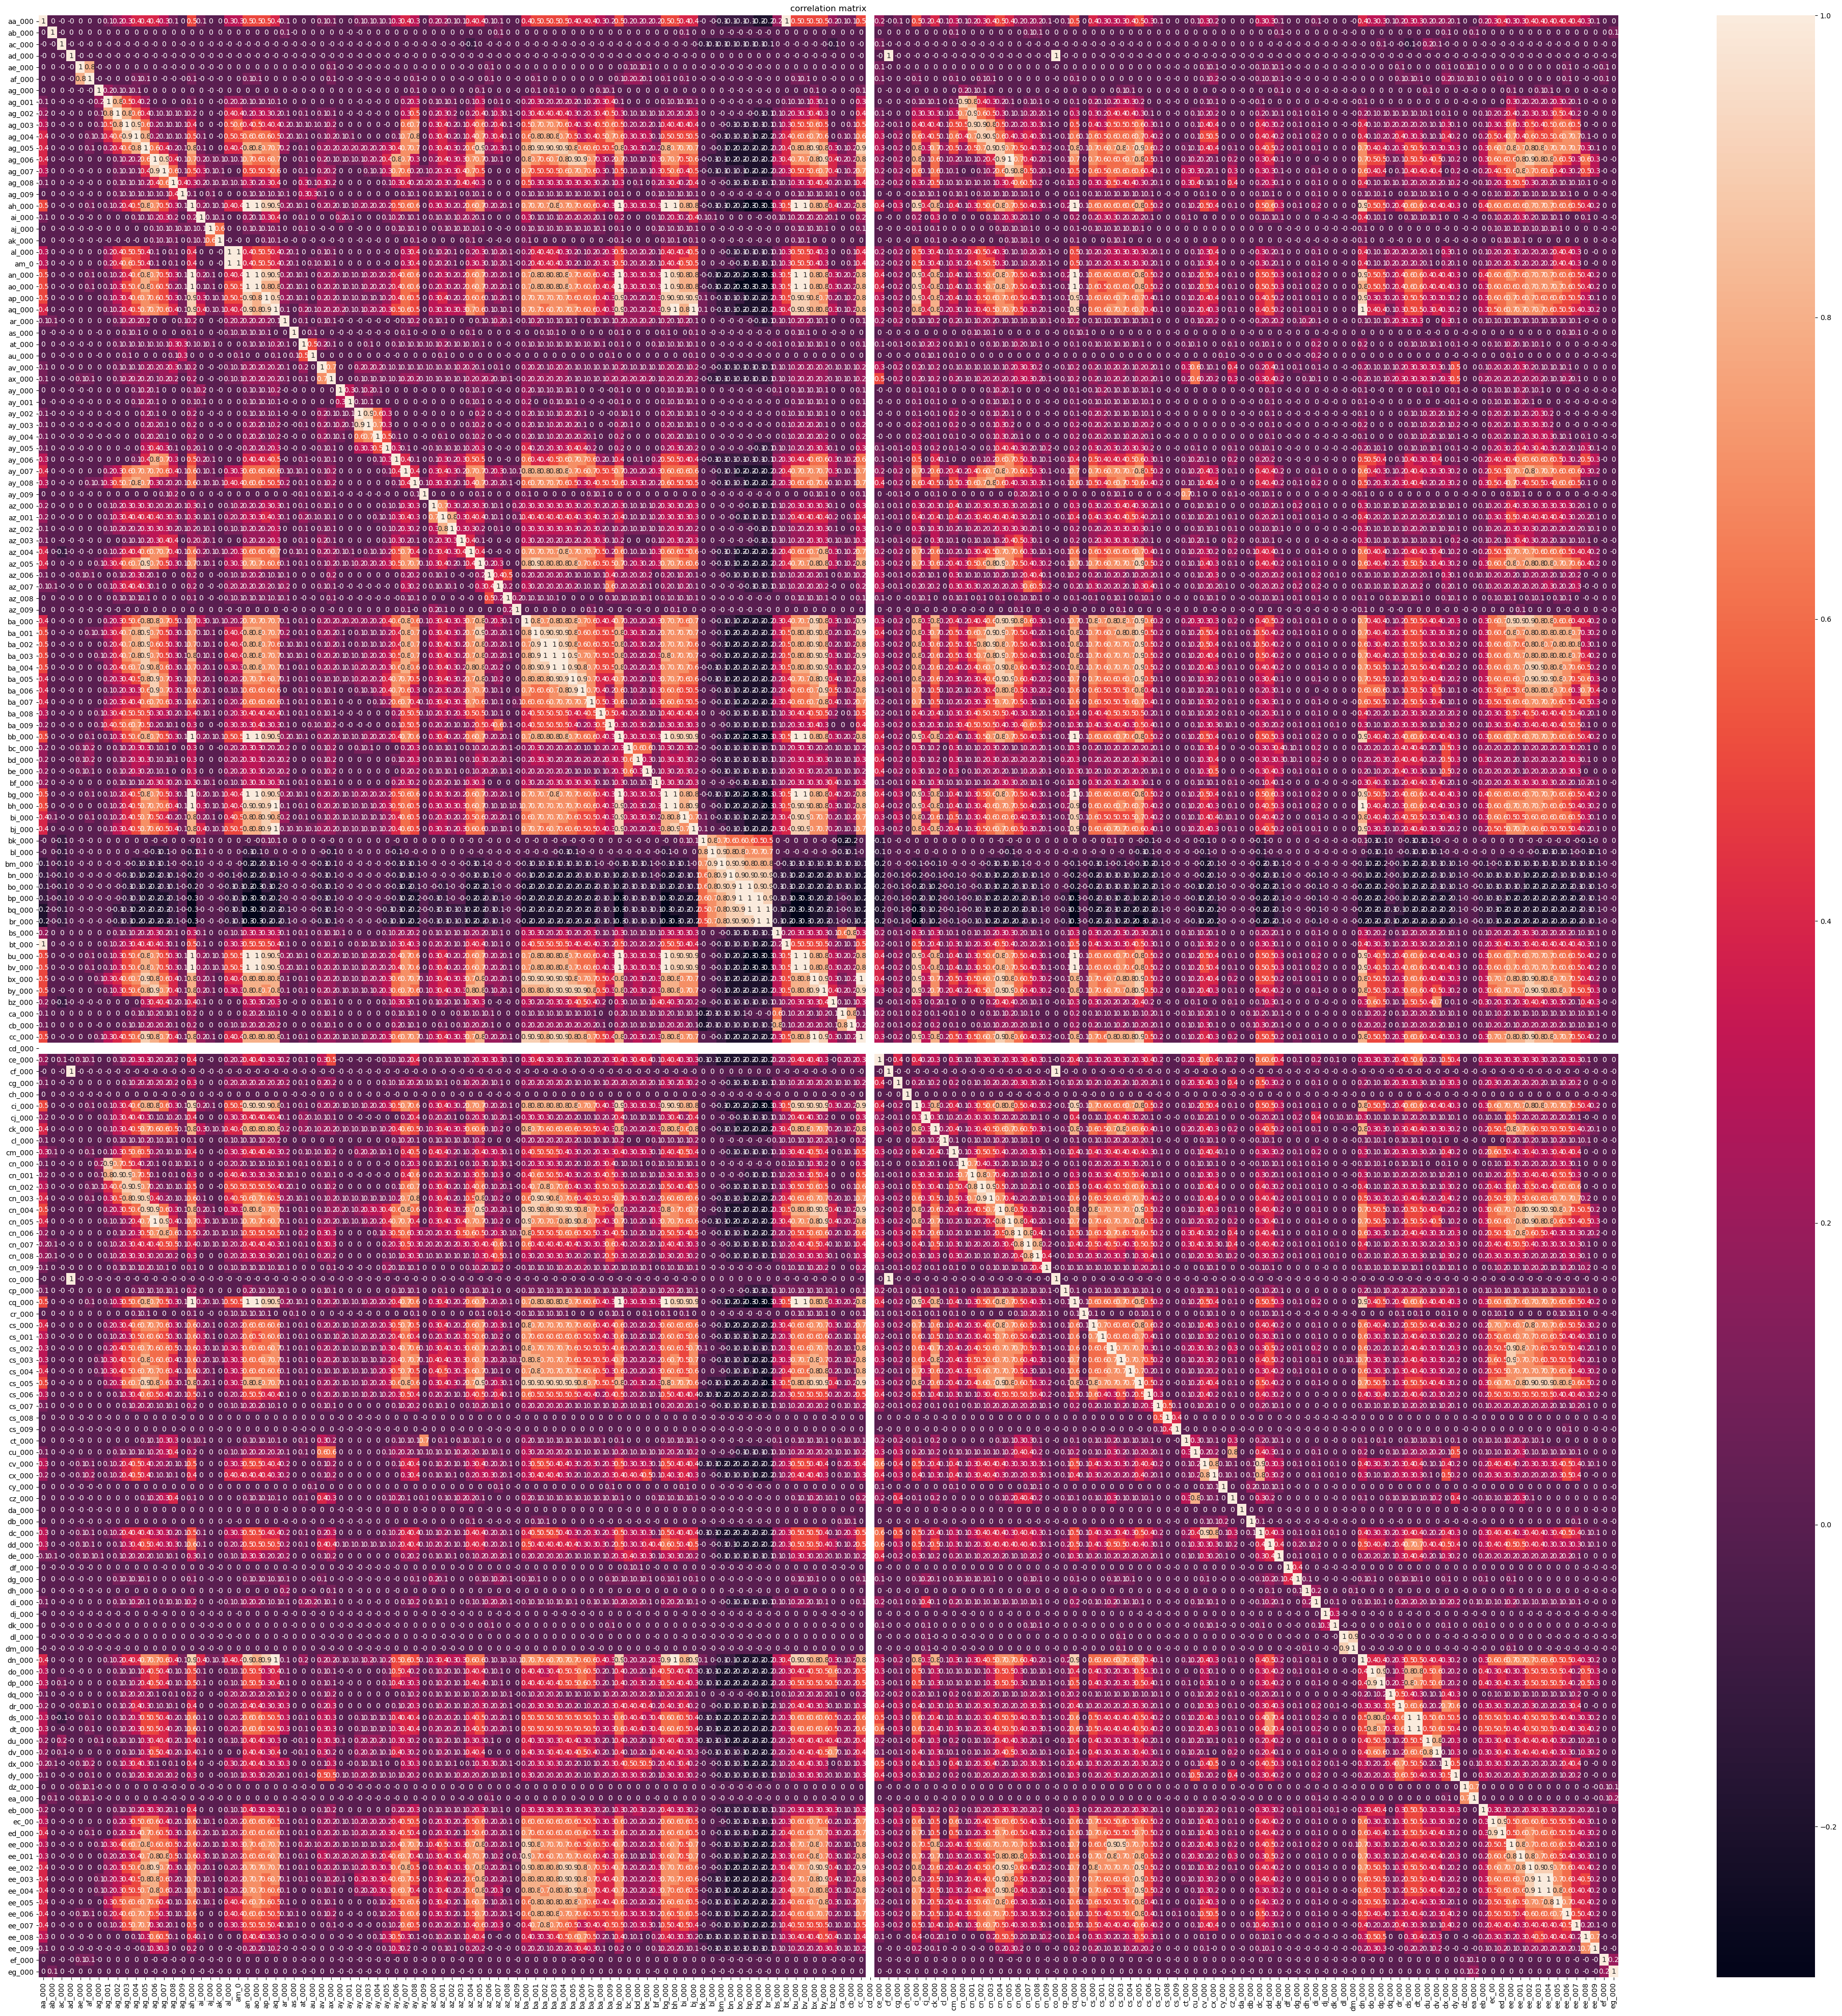

In [5]:
fig = plt.figure() 
plt.rcParams["figure.figsize"]=(5,5)
plt.figure(figsize=(50,50))
ax = sns.heatmap(corr.apply(lambda x: round(x,1)),annot=True)
ax.set_title("correlation matrix")
plt.show()

#### iv. Pick $\lfloor\sqrt{170}\rfloor$ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR.

In [6]:
# Pick features with highest CV
top_num = math.floor(math.sqrt(170))
top_cv = cv.sort_values(ascending=False).head(top_num)
top_f = list(top_cv.index)
df_whole_top = df_whole[top_f]
print("selected features are:",top_f)
df_whole_top

selected features are: ['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'as_000', 'dh_000', 'df_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009']


cf_000         co_000         ad_000  cs_009  dj_000  as_000  \
0           2.000000     220.000000     280.000000     0.0     0.0     0.0   
1      150231.156793  150517.375485  150629.962105     0.0     0.0     0.0   
2           0.000000       0.000000     100.000000     0.0     0.0     0.0   
3           2.000000       2.000000      66.000000     0.0     0.0     0.0   
4           0.000000     202.000000     458.000000     0.0     0.0     0.0   
...              ...            ...            ...     ...     ...     ...   
15995       2.000000      42.000000     892.000000     0.0     0.0     0.0   
15996       2.000000       0.000000      46.000000     0.0     0.0     0.0   
15997       2.000000     378.000000    1518.000000     0.0     0.0     0.0   
15998       0.000000       0.000000      32.000000     0.0     0.0     0.0   
15999       0.000000       0.000000       4.000000     0.0     0.0     0.0   

       dh_000  df_000  ag_000  au_000  ak_000  az_009  ay_009  
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...       ...     ...     ...     ...     ...     ...     ...  
15995     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
15996     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
15997     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
15998     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
15999     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[76000 rows x 13 columns]

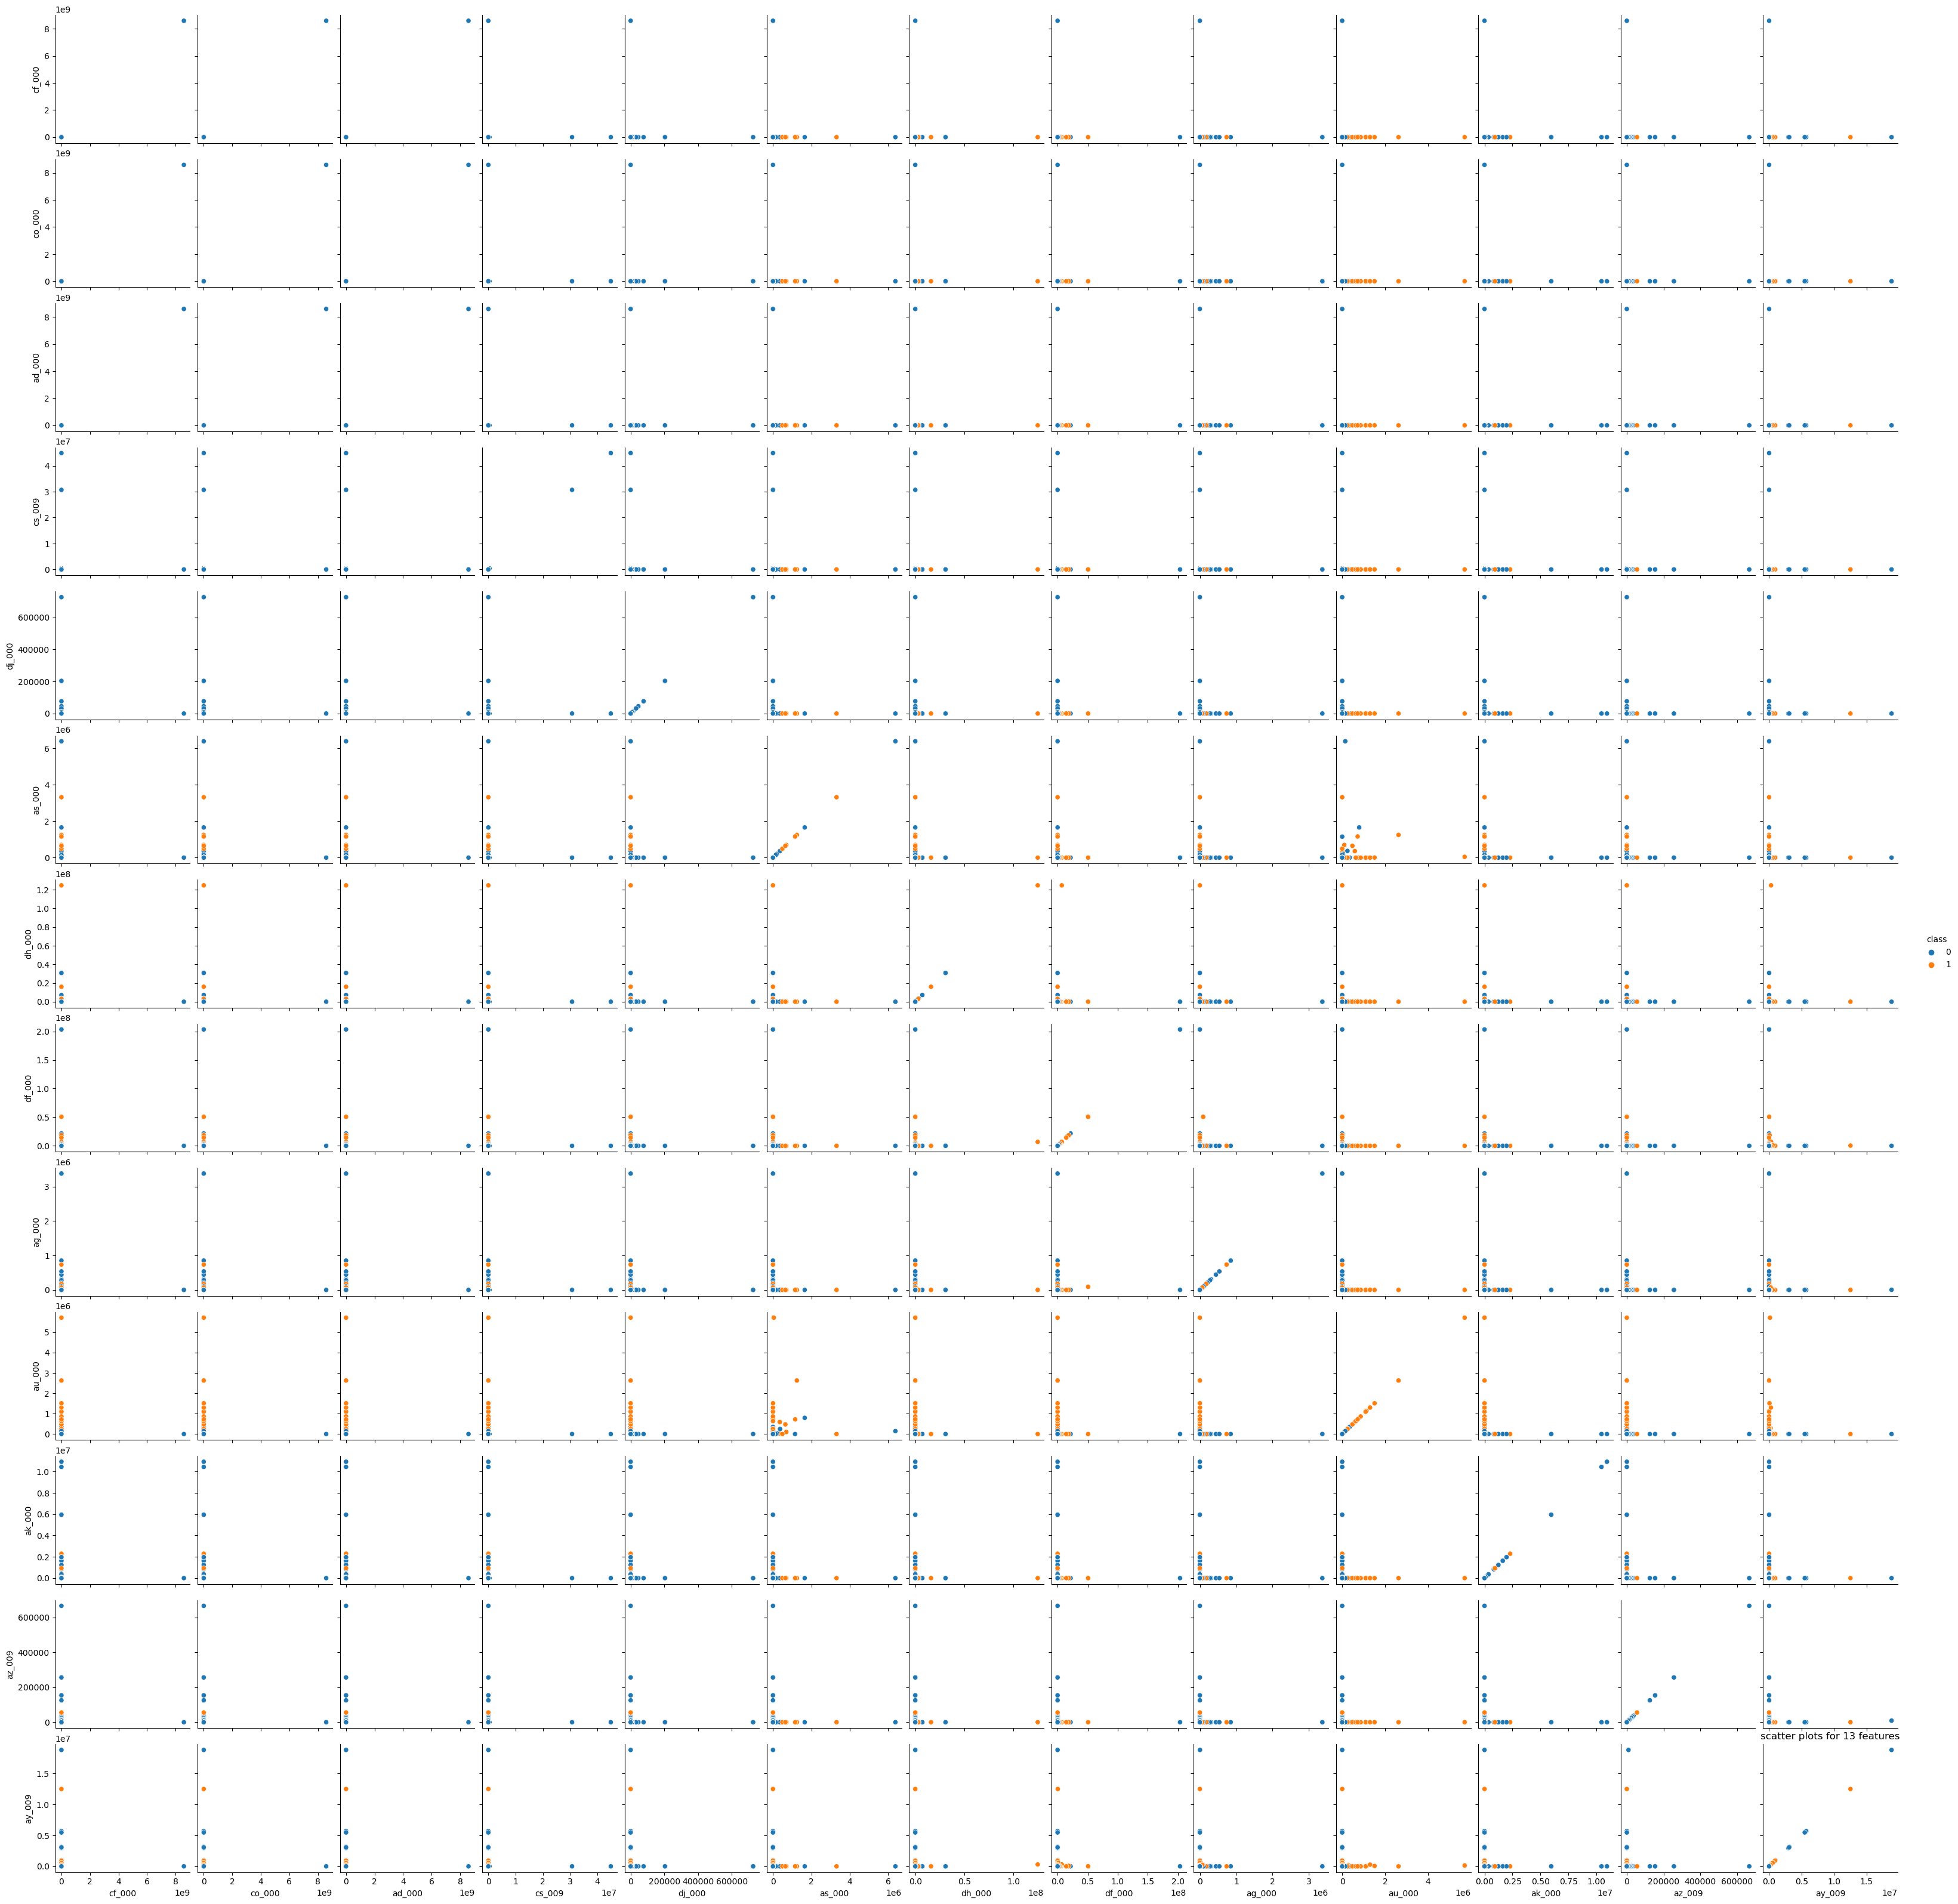

In [7]:
# scatter plots
sns.set_context({'figure.figsize':[15, 15]})
sns.pairplot(pd.concat([df_whole["class"],df_whole_top],axis=1),hue="class",diag_kind=None)
# sns.pairplot(df_whole_top,diag_kind=None)
plt.title('scatter plots for 13 features')
plt.show()

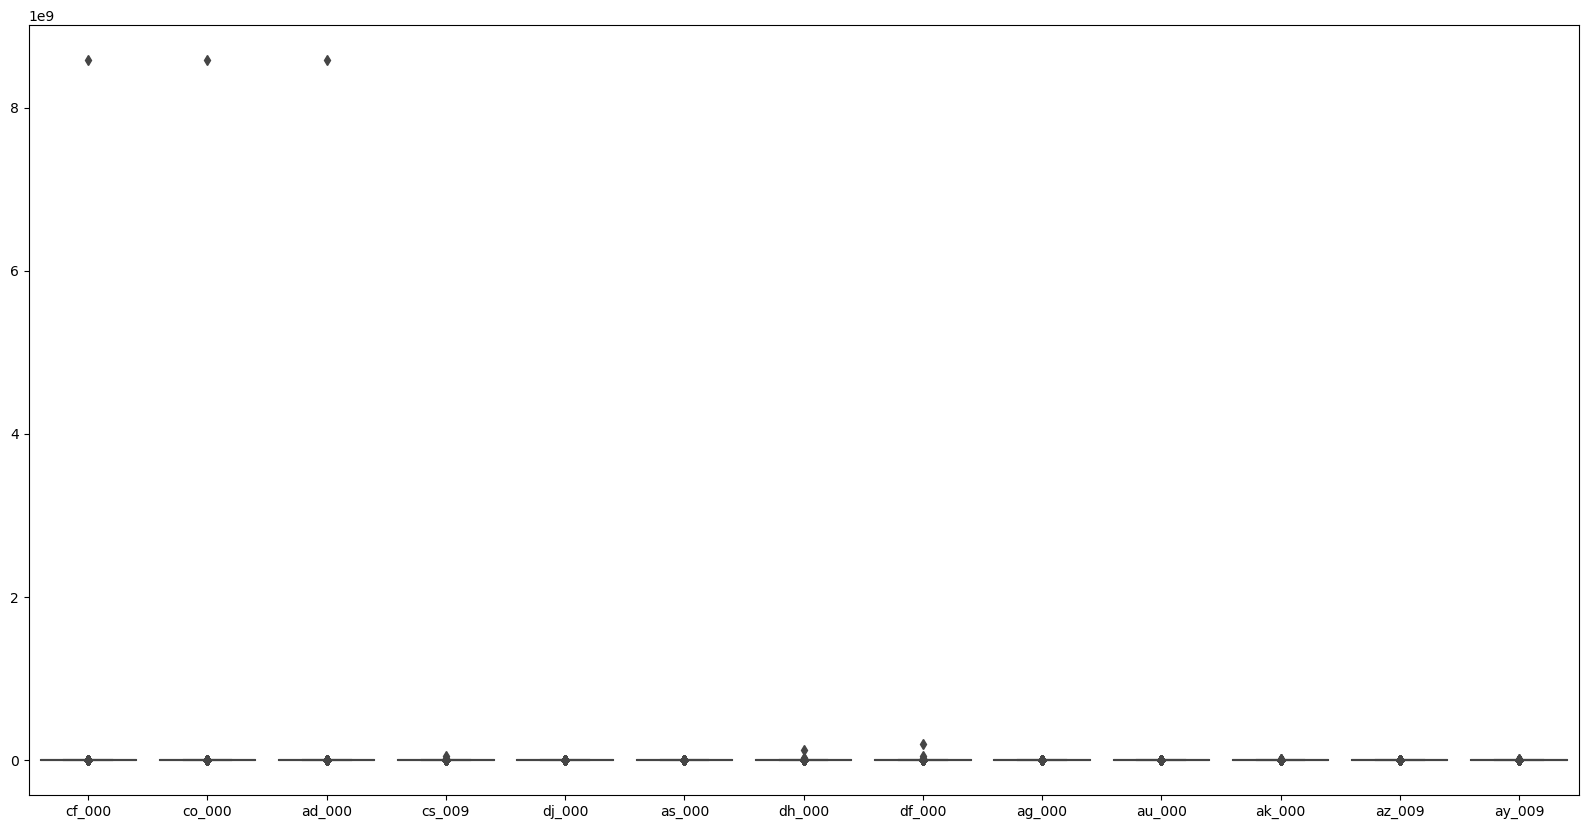

In [8]:
# box plots
ax = sns.boxplot(data=df_whole_top)
ax.figure.set_size_inches(20,10)

Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

    According to the scatter plot, we can see that most pairs of features are not well separated, the data of negative class and positive class are tangled together in the pairplits, so I don't think there features are significant for classification.

#### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [9]:
pos_num = df_whole[df_whole["class"]=="1"].shape[0]
neg_num = df_whole[df_whole["class"]=="0"].shape[0]
print("the number of positive and negative data are:",pos_num,"and",neg_num)

the number of positive and negative data are: 1375 and 74625


In [10]:
pos_ratio = pos_num/(pos_num+neg_num)
pos_ratio

0.018092105263157895

    the ratio of positive data in whole dataset is noly 1.81%, less than 5%, so it can be considered as very severe imbalanced dataset.

### 1.c 
Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. 

In [11]:
x_train = df_train.iloc[:,1:]
y_train = df_train["class"]
x_test = df_test.iloc[:,1:]
y_test = df_test["class"]

In [12]:
rand_clf = RandomForestClassifier(bootstrap=True,oob_score=True)
rand_clf.fit(x_train,y_train)

RandomForestClassifier(oob_score=True)

Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). 

In [13]:
# training set
# confusion matrix 
y_train_pred = rand_clf.predict(x_train)
conf_matrix_train = confusion_matrix(y_train,y_train_pred)
print(conf_matrix_train)

[[59000     0]
 [    1   999]]


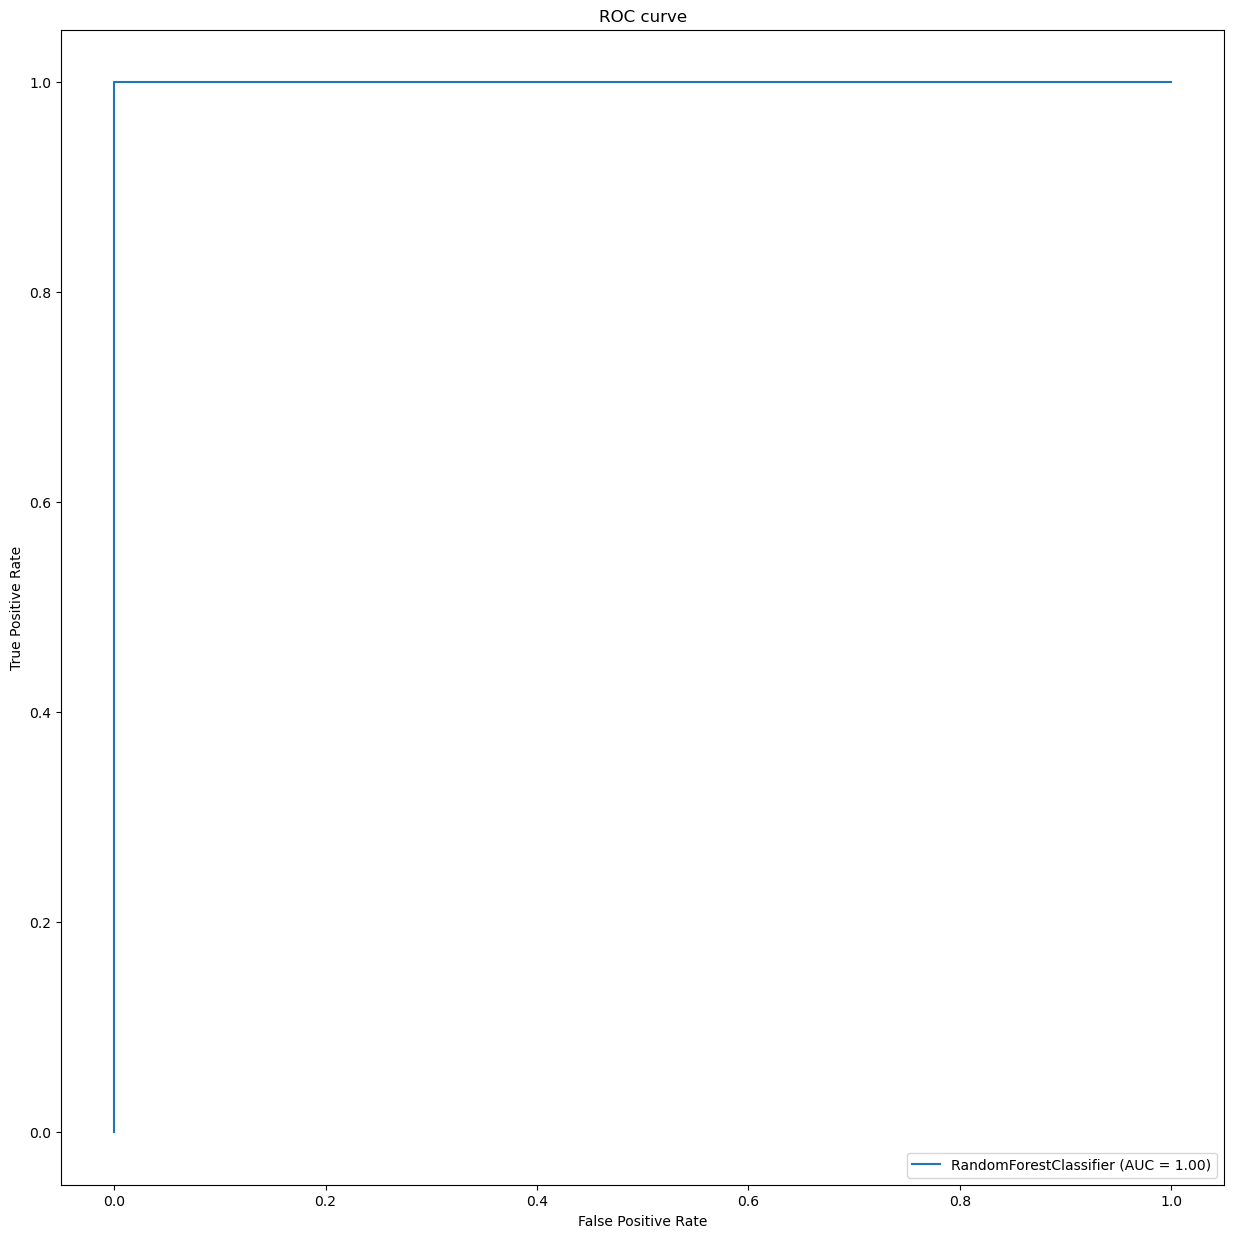

In [14]:
# show ROC and AUC
metrics.plot_roc_curve(rand_clf,x_train,y_train) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [15]:
# misclassification
mis_rate_train = (conf_matrix_train[0][1] + conf_matrix_train[1][0])/len(x_train)
mis_rate_train

1.6666666666666667e-05

In [16]:
# test set
# confusion matrix 
y_test_pred = rand_clf.predict(x_test)
conf_matrix_test = confusion_matrix(y_test,y_test_pred)
print(conf_matrix_test)

[[15610    15]
 [  108   267]]


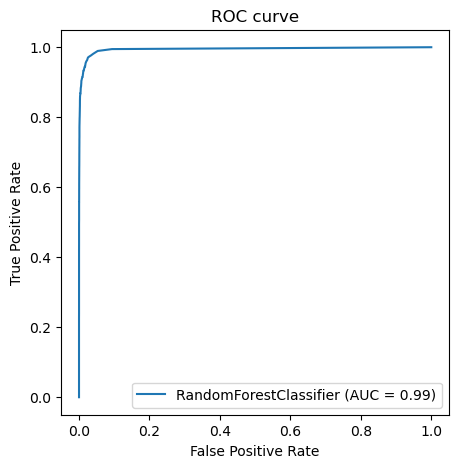

In [17]:
# show ROC and AUC
metrics.plot_roc_curve(rand_clf,x_test,y_test) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [18]:
# misclassification
mis_rate_test = (conf_matrix_test[0][1]+conf_matrix_test[1][0])/len(x_test)
mis_rate_test

0.0076875

Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [19]:
# Out of Bag error estimate
oob_score = rand_clf.oob_score_
test_accuracy = rand_clf.score(x_test,y_test)
comp_table = pd.DataFrame({"oob error":1-oob_score,"test error":1-test_accuracy},index=[0])
comp_table

oob error  test error
0   0.006033    0.007687

    from the previous cell, we can see that Out of Bag error estimate is 0.006 and test error is 0.008, a little lower than oob error estimate.

### 1.d
Research how class imbalance is addressed in random forests. 

There are mainly two methods can solve problem of class imbalance:
1. resampling, for example oversampling like SMOTE and undersampling
2. cost-sensitive approach, which assigns different weights to different classes

Compensate for class imbalance in your random forest and repeat 1c.


In [20]:
balance_clf = RandomForestClassifier(class_weight="balanced",bootstrap=True,oob_score=True)
balance_clf.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', oob_score=True)

In [21]:
# training set
# confusion matrix 
y_train_pred = balance_clf.predict(x_train)
conf_matrix_train = confusion_matrix(y_train,y_train_pred)
print(conf_matrix_train)

[[59000     0]
 [    0  1000]]


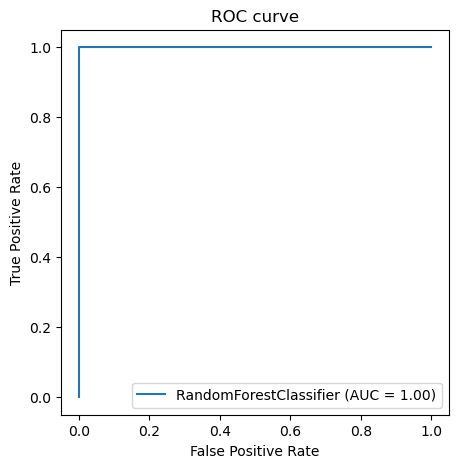

In [22]:
# show ROC and AUC
metrics.plot_roc_curve(balance_clf,x_train,y_train) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [23]:
# misclassification
mis_rate_train = (conf_matrix_train[0][1] + conf_matrix_train[1][0])/len(x_train)
mis_rate_train

0.0

In [24]:
# test set
# confusion matrix 
y_test_pred = balance_clf.predict(x_test)
conf_matrix_test = confusion_matrix(y_test,y_test_pred)
print(conf_matrix_test)

[[15612    13]
 [  161   214]]


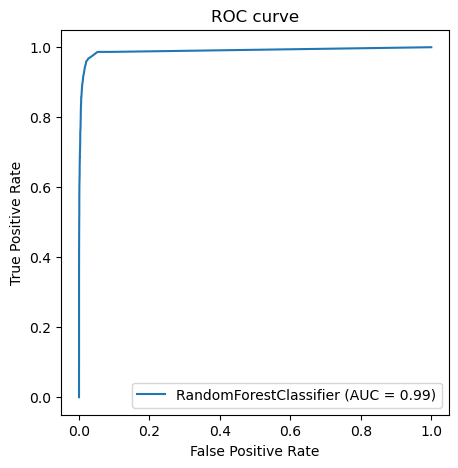

In [25]:
# show ROC and AUC
metrics.plot_roc_curve(balance_clf,x_test,y_test) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [26]:
# misclassification
mis_rate_test = (conf_matrix_test[0][1]+conf_matrix_test[1][0])/len(x_test)
mis_rate_test

0.010875

Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [27]:
# Out of Bag error estimate
oob_score = balance_clf.oob_score_
test_accuracy = balance_clf.score(x_test,y_test)
balance_comp_table = pd.DataFrame({"oob error":1-oob_score,"test error":1-test_accuracy},index=[0])
balance_comp_table

oob error  test error
0   0.007967    0.010875

    from previoue cell, we can see that Out of Bag error estimate is 0.008 and test error is 0.011, much lower than oob error estimate.

Compare the results with those of 1c.

In [28]:
comp_balance = pd.concat([comp_table,balance_comp_table],ignore_index=True)
comp_balance.index = ["imbalance","balanced"]
comp_balance

oob error  test error
imbalance   0.006033    0.007687
balanced    0.007967    0.010875

    from previoue table, we can see that errors for both training set and test set become higher after the compensation for class imbalance, may show that compensating the imbalance of class can make model less overfitting, even though the difference between oob error estimate and test error extends very little.

### 1.e XGBoost and Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split. 
In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. 
In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. 
In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using ${X}_{j}$ > s as the decision rule, one has $\displaystyle\sum_{j}{\beta_{j}}{X}_{j}$ > s. as the decision rule). 
Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can **use L1-penalized logistic regression at each node**. You can use **XGBoost** to fit the model tree. **Determine α (the regularization term) using cross-validation**. **Train the model for the APS data set without compensation for class imbalance**. **Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model** and **compare it with the test error**. **Report the Confusion Matrix, ROC, and AUC for training and test sets**.


In [29]:
# use XGBoost to fit the model tree and choose alpha

# xgb_clf = xgb.XGBClassifier()
# param_grid = {"reg_alpha":np.arange(0.1,1.5,0.1)} 
# grid_search = GridSearchCV(xgb_clf,param_grid,cv=5)
# grid_search = grid_search.fit(x_train,y_train.astype(int))
# alpha = grid _search.best_params_["reg_alpha"]
# alpha

para_alphas = list(np.arange(0.5,1.5,0.1))
cv_score = {}
for alpha in para_alphas:
    xgb_clf = xgb.XGBClassifier(objective="reg:logistic",reg_alpha=alpha)
#     xgb_clf.fit(x_train,y_train,eval_metric='logloss')
    score = cross_val_score(xgb_clf,x_train,y_train.astype(int),cv=5).mean()
    cv_score[alpha] = score
    print(alpha,score)

0.5 0.9947000000000001
0.6 0.9944666666666666
0.7 0.9944166666666667
0.7999999999999999 0.9946333333333334
0.8999999999999999 0.9943833333333334
0.9999999999999999 0.9944166666666667
1.0999999999999999 0.9945833333333333
1.1999999999999997 0.9946833333333333
1.2999999999999998 0.99475
1.4 0.9945999999999999


In [30]:
best_alpha = max(cv_score, key=cv_score.get)
print("best alpha is:",best_alpha,"and its cv score is:",cv_score[best_alpha])

best alpha is: 1.2999999999999998 and its cv score is: 0.99475


In [31]:
# refit xgboost model with chosen alpha
# and Use 5 fold to estimate the error of trained model
# and compare with test error
xgb_clf = xgb.XGBClassifier(objective='reg:logistic',reg_alpha=best_alpha)
xgb_clf.fit(x_train,y_train.astype(int),eval_metric='logloss')
train_score = cross_val_score(xgb_clf,x_train,y_train.astype(int),cv=5).mean()
test_score = xgb_clf.score(x_test,y_test.astype(int))
print("train error is ",1-train_score,"\ntest error is ",1-test_score)

train error is  0.005249999999999977 
test error is  0.005750000000000033


    test error is a little higher than train error

[[59000     0]
 [    1   999]]


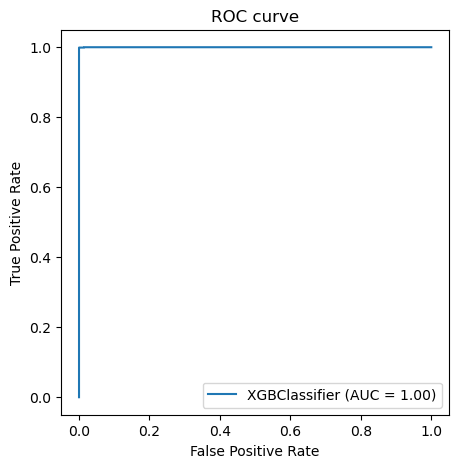

In [32]:
# train set
# confusion matrix 
y_train_pred = xgb_clf.predict(x_train)
conf_matrix_train = confusion_matrix(y_train.astype(int),y_train_pred)
print(conf_matrix_train)

# show ROC and AUC
metrics.plot_roc_curve(xgb_clf,x_train,y_train.astype(int)) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

[[15610    15]
 [   77   298]]


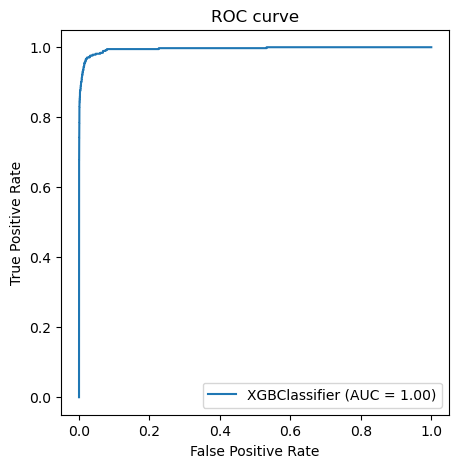

In [33]:
# test set
# confusion matrix 
y_test_pred = xgb_clf.predict(x_test)
conf_matrix_test = confusion_matrix(y_test.astype(int),y_test_pred)
print(conf_matrix_test)

# show ROC and AUC
metrics.plot_roc_curve(xgb_clf,x_test,y_test.astype(int)) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

### 1.f
Use SMOTE to pre-process your data to compensate for class imbalance.

In [34]:
smo = SMOTE()
x_train_smo,y_train_smo = smo.fit_resample(x_train,y_train)

Train XGBosst with L1-penalized lo- gistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. 

In [35]:
# repeat 1e
# right way is to apply cross validation to both the selection of predictors and the selection of models
# use XGBoost to fit the model tree and choose alpha
para_alphas = list(np.arange(0.5,1.5,0.1))
cv_score = {}
for alpha in para_alphas:
    xgb_clf_smo = xgb.XGBClassifier(objective="reg:logistic",reg_alpha=alpha)
#     xgb_clf.fit(x_train,y_train,eval_metric='logloss')
    score = cross_val_score(xgb_clf_smo,x_train_smo,y_train_smo.astype(int),cv=5).mean()
    cv_score[alpha] = score
    print(alpha,score)

0.5 0.9973389830508473
0.6 0.997177966101695
0.7 0.9972118644067797
0.7999999999999999 0.9972542372881357
0.8999999999999999 0.99735593220339
0.9999999999999999 0.9973813559322033
1.0999999999999999 0.9973898305084745
1.1999999999999997 0.9972796610169492
1.2999999999999998 0.997177966101695
1.4 0.997364406779661


In [36]:
best_alpha = max(cv_score, key=cv_score.get)
print("best alpha is:",best_alpha,"and its cv score is:",cv_score[best_alpha])

best alpha is: 1.0999999999999999 and its cv score is: 0.9973898305084745


In [37]:
# refit xgboost model with chosen alpha
# and Use 5 fold to estimate the error of trained model
# and compare with test error
xgb_clf_smo = xgb.XGBClassifier(objective='reg:logistic',reg_alpha=best_alpha)
xgb_clf_smo.fit(x_train_smo,y_train_smo.astype(int),eval_metric='logloss')
train_score_smo = cross_val_score(xgb_clf_smo,x_train_smo,y_train_smo.astype(int),cv=5).mean()
test_score_smo = xgb_clf_smo.score(x_test,y_test.astype(int))
print("train error is ",1-train_score_smo,"\ntest error is ",1-test_score_smo)

train error is  0.0026101694915254825 
test error is  0.0063750000000000195


    test error is much higher than train error

[[59000     0]
 [    2 58998]]


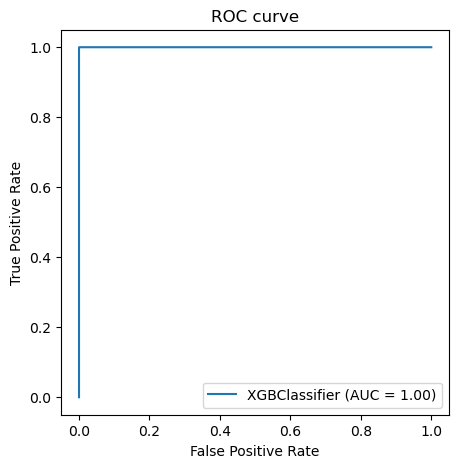

In [38]:
# train set
# confusion matrix 
y_train_smo_pred = xgb_clf_smo.predict(x_train_smo)
conf_matrix_train = confusion_matrix(y_train_smo.astype(int),y_train_smo_pred)
print(conf_matrix_train)

# show ROC and AUC
metrics.plot_roc_curve(xgb_clf_smo,x_train_smo,y_train_smo.astype(int)) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

[[15610    15]
 [   77   298]]


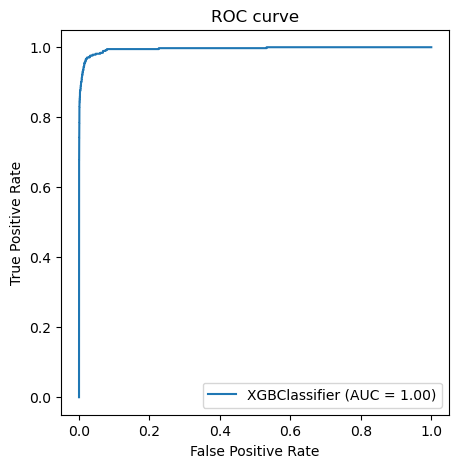

In [39]:
# test set
# confusion matrix 
y_test_pred = xgb_clf.predict(x_test)
conf_matrix_test = confusion_matrix(y_test.astype(int),y_test_pred)
print(conf_matrix_test)

# show ROC and AUC
metrics.plot_roc_curve(xgb_clf,x_test,y_test.astype(int)) 
sns.set_context({"figure.figsize":[5, 5]})
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

Compare the uncompensated case with SMOTE case.

In [42]:
pd.DataFrame({
    "type":["imbalance","balanced"],
    "train error":[1-train_score,1-train_score_smo],
    "test error":[1-test_score,1-test_score_smo]
})

type  train error  test error
0  imbalance      0.00525    0.005750
1   balanced      0.00261    0.006375

    from the above table, we can see that after compensation for imbalance data, training error decreases a lot while test error increases, may show that compensating the imbalance of class can make model more overfitting. 

### 2. ISLR 6.6.3
Suppose we estimate the regression coefficients in a linear regression model by minimizing $\displaystyle\sum^{n}_{i=1}({y}_i-{\beta}_0-\displaystyle\sum^{p}_{j=1}{\beta}_j{x}_{ij})^2$ subject to $\displaystyle\sum^{p}_{j=1}{|{\beta}_j|}\leq s$ for a particular value of s. 

For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

(a) As we increase s from 0, the training RSS will:

i. Increase initially, and then eventually start decreasing in an inverted U shape.
    
ii. Decrease initially, and then eventually start increasing in a U shape.

iii. Steadily increase. 

iv. Steadily decrease. 

v. Remain constant.

    iv is true.
    Because when we increase s from 0, our restriction on Bj becomes less strict, so the model will become more flexible. So training RSS will decrease steadily

(b) Repeat (a) for test RSS. 

    ii is correct.
    As saying in (a), the model will become more and more flexible, meaning that it is becoming more and more fitting to training and then to be overfitting. So test RSS will decrease first, then increase.

(c) Repeat (a) for variance.

    iii is correct.
    Because when we increase s from 0, our restriction on Bj becomes less strict so the model will become more flexible. This means that the model becomes less biased and according to bias-variance trade-off, its variance will increase steadily.

(d) Repeat (a) for (squared) bias.

    iv is correct.
    Because when we increase s from 0, our restriction on Bj becomes less strict so the model will become more flexible. This means that the model becomes less biased, so its squared bias will steadily decrease.

(e) Repeat (a) for the irreducible error.

    v is correct.
    Because the error is irreducible, meaning it's independant to the model. So change the coefficients of model will not change the irreducible error.

### 3. ISLR 6.6.5
It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.

Suppose that n=2, p=2, ${x_{11}}$=${x_{12}}$, ${x_{21}}$=${x_{22}}$. Furthermore, supposethat ${y_{1}}$+${y_{2}}$=0 and ${x_{11}}$+${x_{21}}$=0 and ${x_{12}}$+${x_{22}}$=0, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: $\hat{\beta_{0}}$=0.

(a) Write out the ridge regression optimization problem in this setting.

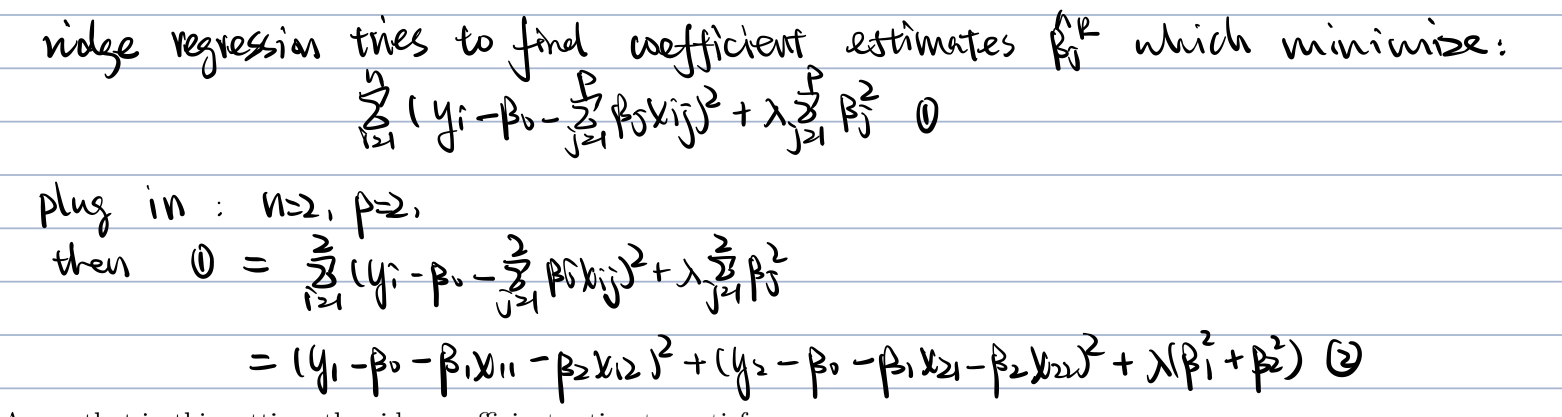

(b) Argue that in this setting, the ridge coefficient estimates satisfy $\hat{\beta_{1}}$=$\hat{\beta_{2}}$ .

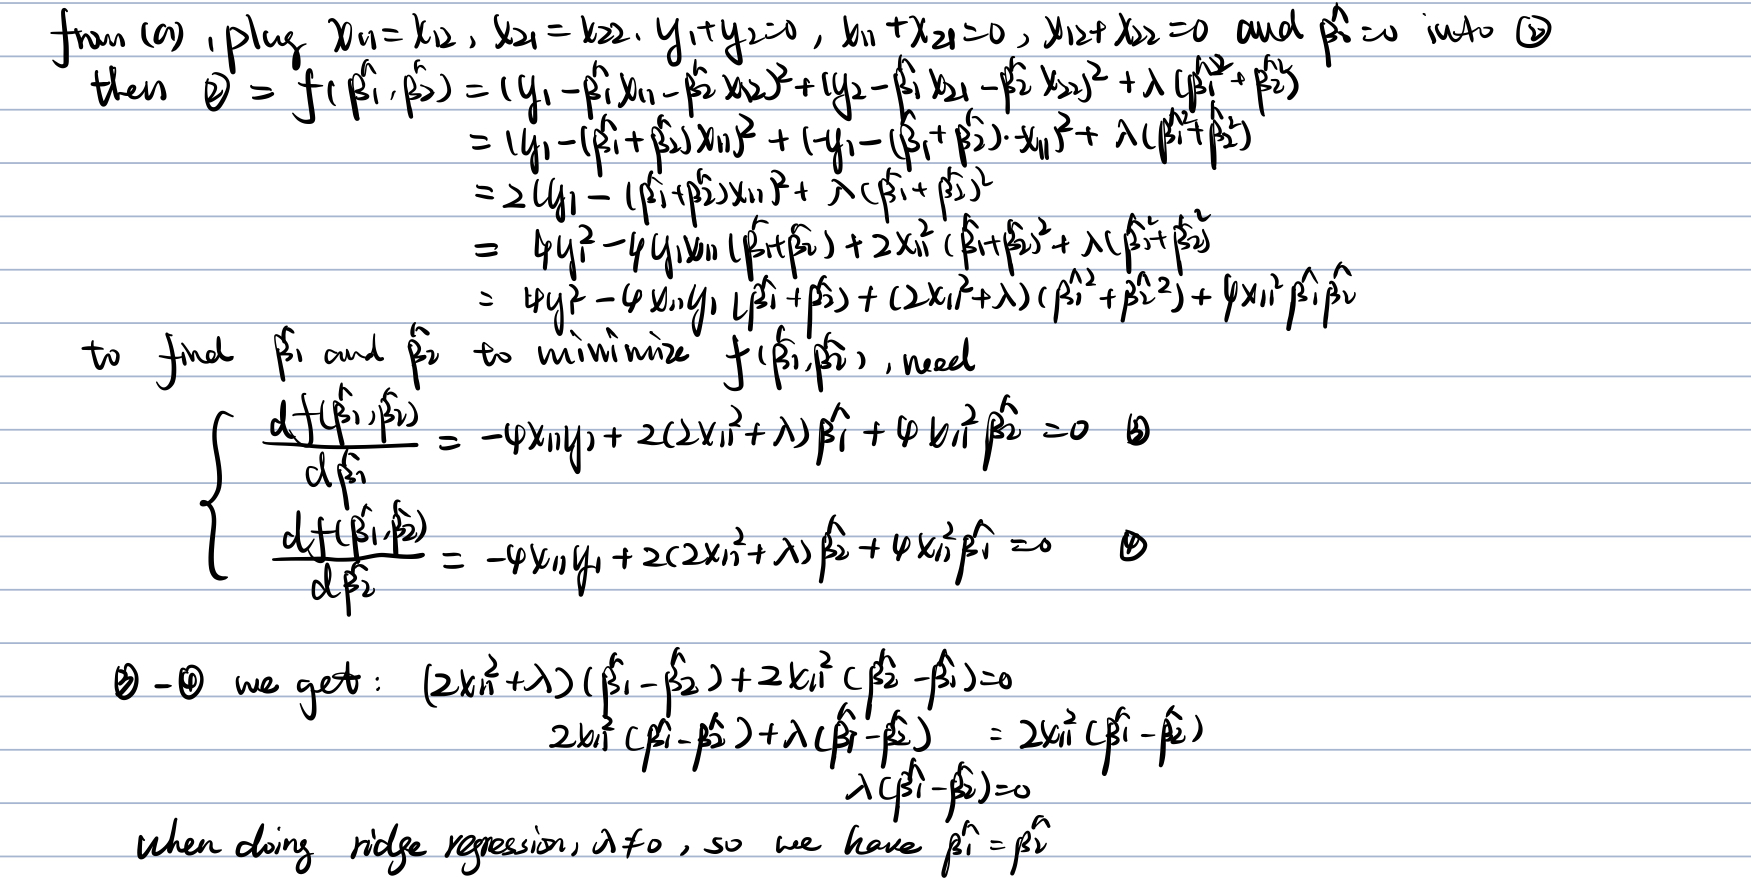

(c) Write out the lasso optimization problem in this setting.

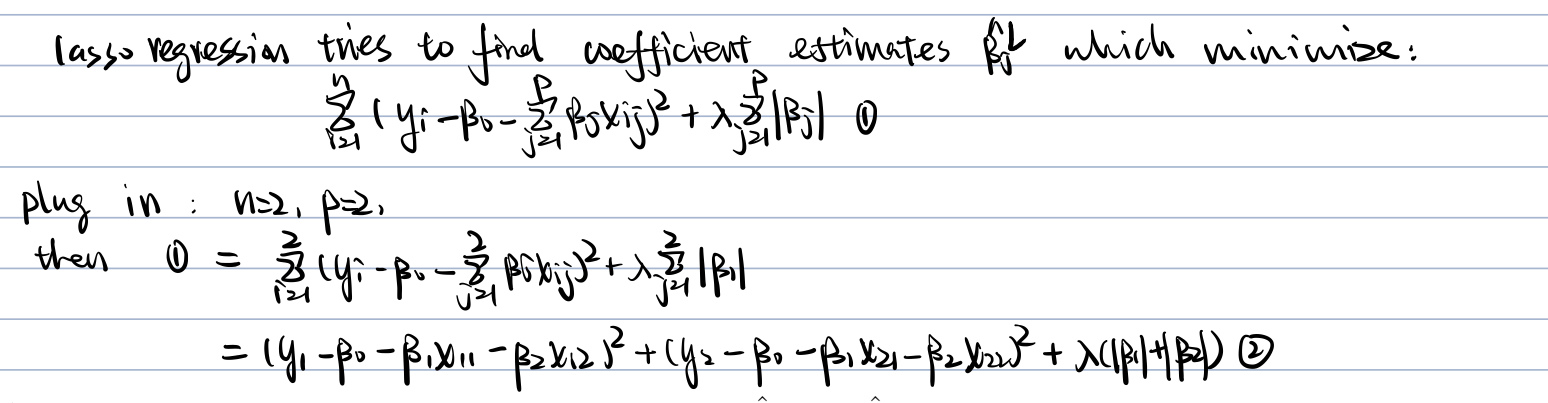

(d) Argue that in this setting, the lasso coefficients $\hat{\beta_{1}}$ and $\hat{\beta_{2}}$ are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

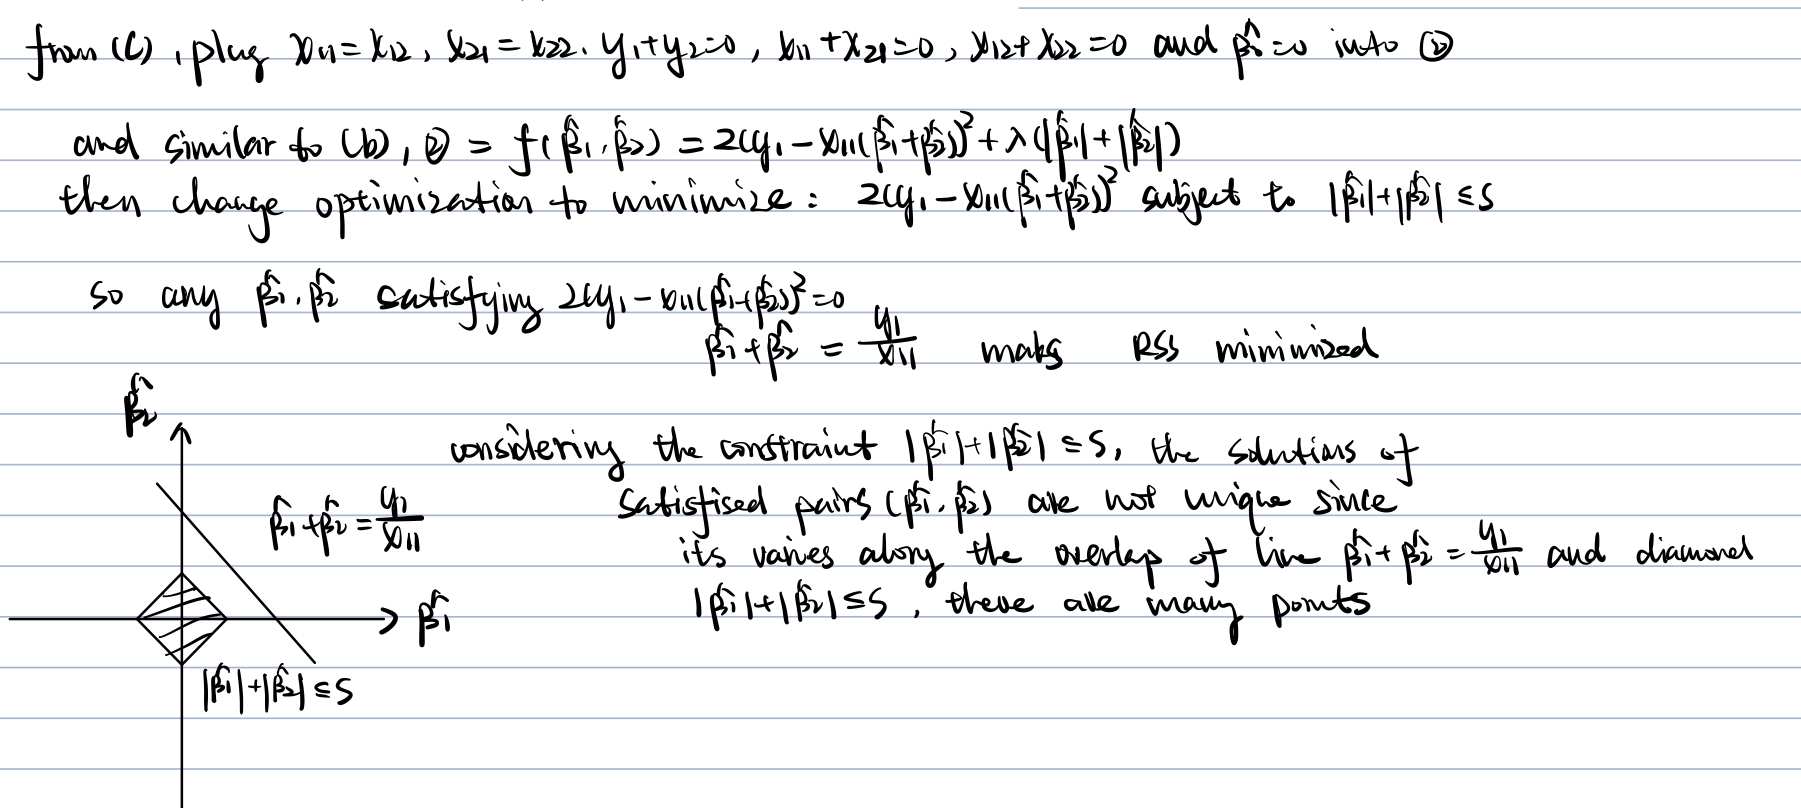

### 4. ISLR 8.4.5
Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X):

    0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7, and 0.75.

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

1. majority vote:
        for each 10 estimates, there are 4 green and 6 red, so final classification will be red under majority vote approach

2. average probability:
        the average probability is (0.1+0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+0.75)/10 = 0.45, less than 0.5 so final classification will be green under this approach

### 5. ISLR 9.7.3
Here we explore the maximal margin classifier on a toy data set.

(a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label.

|Obs.|X1|X2|Y|
|----|--|--|-|
|1   |3 |4|Red|
|2   |2 |2|Red|
|3   |4 |4|Red|
|4   |1 |4|Red| 
|5   |2 |1|Blue|
|6   |4 |3|Blue|
|7   |4 |1|Blue| 

Sketch the observations.

(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).

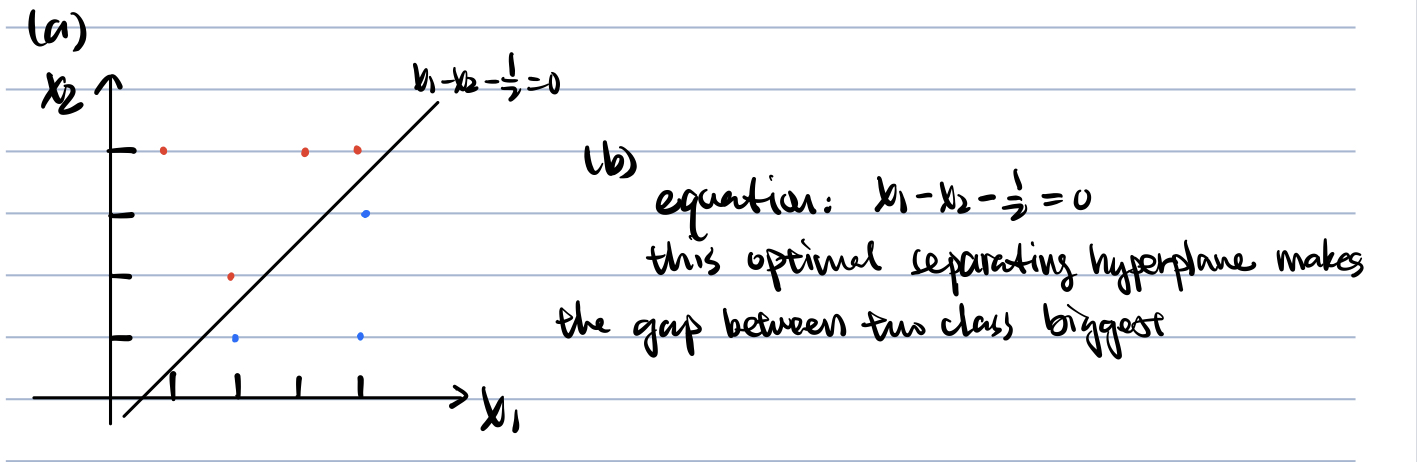

(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if ${\beta_{0}}$+${\beta_{1}}{X_{1}}$+${\beta_{2}}{X_{2}}$> 0, and classify to Blue otherwise.” Provide the values for ${\beta_{0}}$, ${\beta_{1}}$, and ${\beta_{2}}$.

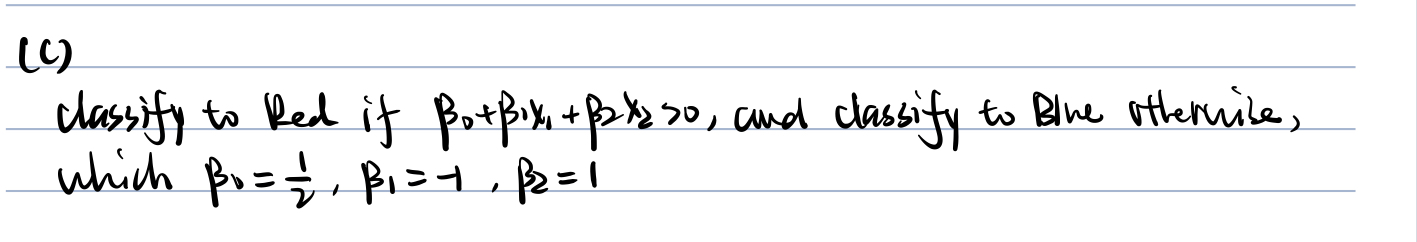

(d) On your sketch, indicate the margin for the maximal margin hyperplane

(e) Indicate the support vectors for the maximal margin classifier.

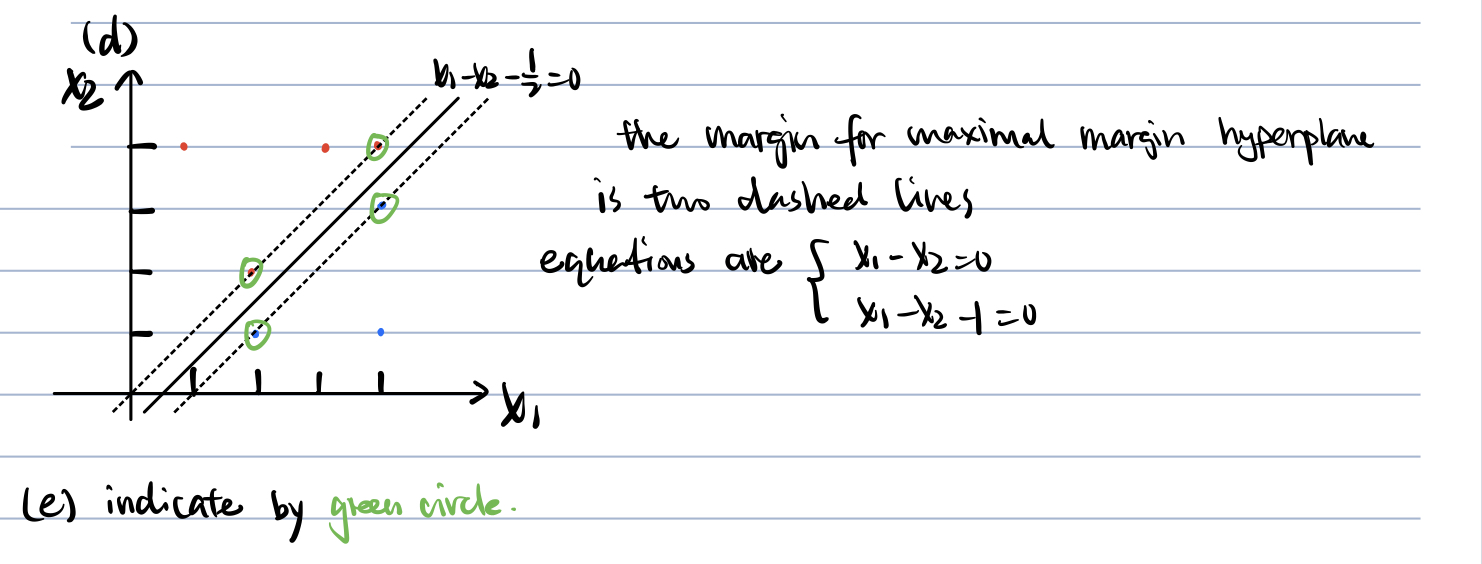

(f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

    Only if it moves inside the margin for the maximal margin hyperplane can influence the position of the maximal margin hyperplane. However we the seventh observation is not a support vector and aslo its position is far away from the right margin, so the slight movement of it would not affect the maximal margin hyperplane.

(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

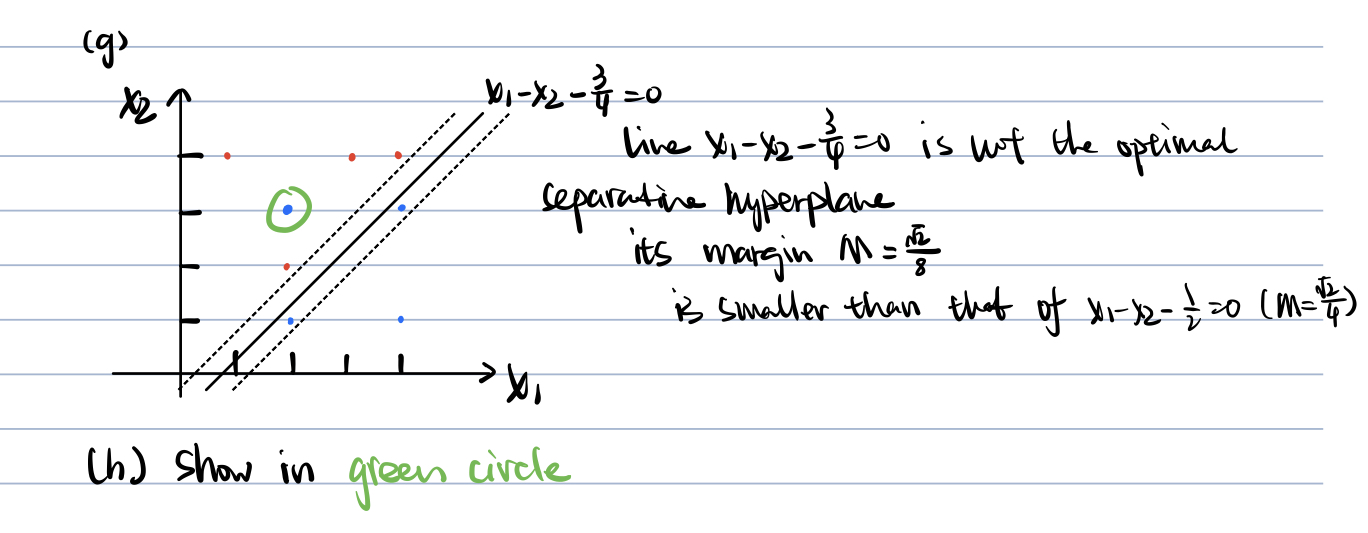